## Copie manuelle de l'implémentation de DQN pour l'environnement Gym CartPole d'après le livre Hands-On Machine Learning 2nd édition by Aurélien Géron p.634

Ce notebook est juste une copie manuelle du DQN proposé par [Aurélien Géron](https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb) pour maîtriser l'équilibre d'un pendule inversé. Il vise uniquement à s'approprier les techniques de codage pour avoir une base performante avant de complexifier l'environnement et la tâche à réaliser par l'agent. 

A noter que l'affichage qui permet en général d'attester la qualité et la performance d'un DQN présente la somme des récompenses par épisode et non la loss qui n'est pas représentative. 

In [1]:
import gym
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from tqdm import tqdm

In [2]:
env = gym.make("CartPole-v0")
input_shape=[4]
n_outputs=2

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [3]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [4]:
from collections import deque

replay_buffer = deque(maxlen=2000)

In [5]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [6]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [7]:
batch_size = 32
gamma = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1-dones) * gamma * max_next_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [8]:
rewards=[]

for episode in tqdm(range(600)):
    obs = env.reset()
    sum=0
    for step in range(200):
        epsilon = max(1 - episode/500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
        sum+=reward
    rewards.append(sum)
    if episode > 50:
        training_step(batch_size)

100%|██████████| 600/600 [36:42<00:00,  3.67s/it]


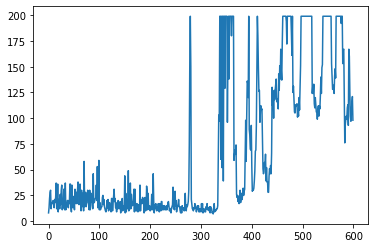

In [10]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.show()